<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/tinygp_practice_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing packages
!pip install jaxopt
!pip install tinygp

In [ ]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jaxopt
import tinygp
jax.config.update("jax_enable_x64", True)

In [ ]:
#Plotting heat-map function (y_pred, y_true, variance)
def plotheatmap(X, y_pred, y_true, var):
  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
  axes[0].plot(xy[0], xy[1], "--k", lw=0.5)
  axes[0].pcolor(X[:,0], X[:,1], y_pred, vmin=y_pred.min(), vmax=y_pred.max())
  axes[1].pcolor(X[:,0], X[:,1], y_true, vmin=y_true.min(), vmax=y_true.max())
  axes[2].pcolor(X[:,0], X[:,1], var)
  axes[0].set_xlabel("x1")
  axes[0].set_ylabel("x2")
  axes[0].set_title("y_pred")
  axes[1].set_xlabel("x1")
  axes[1].set_ylabel("x2")
  axes[1].set_title("y_true")
  axes[2].set_xlabel("x1")
  axes[2].set_ylabel("x2")
  axes[2].set_title("variance")
  return

Maximum likelihood parameters:
{'log_amp': DeviceArray(0.3, dtype=float64), 'log_scale': DeviceArray([0., 0.], dtype=float64)}
Predicted minimum y value using GP: -0.07953649861053572


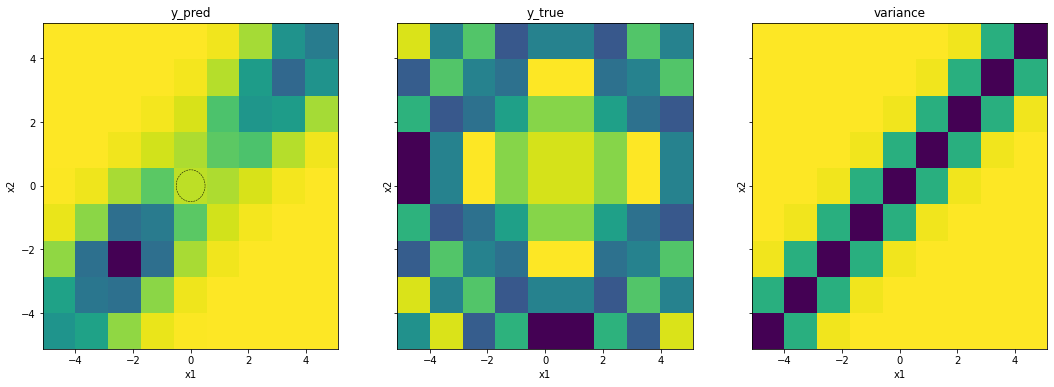

In [ ]:
#plotting for simple function as practice
#drop-wave function

#description of function
X = np.linspace((-5.12,-5.12),(5.12,5.12),10)
yerr = 0.01
y = -(1+np.cos(12*np.sqrt(X[:, 0]**2+X[:, 1]**2)))/(0.5*(X[:, 0]**2+X[:, 1]**2)+2) + yerr * np.random.normal(
    size=len(X))
X1,X2 = np.meshgrid(X[:,0], X[:,1])
y_true = -(1+np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2)

#Gaussian noise
obs = -(1+np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2) + + yerr * np.random.normal(
    size=len(X))
X_pred = np.vstack((X1.flatten(), X2.flatten())).T

#hyperparameters
params = {
        "log_amp": np.float64(0.3),
        "log_scale": np.zeros(2),
    }

#Kernel = Matern52
kernel = jnp.exp(params["log_amp"]) * tinygp.transforms.Linear(
        jnp.exp(-params["log_scale"]), tinygp.kernels.Matern52()
    )
gp = tinygp.GaussianProcess(kernel, X, diag=yerr**2)

#loss function
@jax.jit
def loss(params):
    return gp.log_probability(y)

#minimizing loss function
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(params)
print("Maximum likelihood parameters:")
print(soln.params)

y_pred = gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)

#finding mean and variance
gp_cond = gp.condition(y, X_pred).gp
mu, var = gp_cond.loc, gp_cond.variance
var = var.reshape(y_true.shape)

#Producing covariance elcipse
theta = np.linspace(0, 2 * np.pi, 500)[None, :]
ellipse = 0.5 * np.concatenate((np.cos(theta), np.sin(theta)), axis=0)
xy = ellipse / gp.kernel.kernel2.scale[:, None]

#Plotting results in heatmap
plotheatmap(X, y_pred, y_true, var)

#printing results, comparing trained(predicted) data vs. true value
print(f"Predicted minimum y value using GP: {y_pred.min()}")

Maximum likelihood parameters:
{'log_amp': DeviceArray(0.3, dtype=float64), 'log_scale': DeviceArray([0., 0.], dtype=float64)}
Predicted minimum y value using GP: 4.9154409017147324e-185


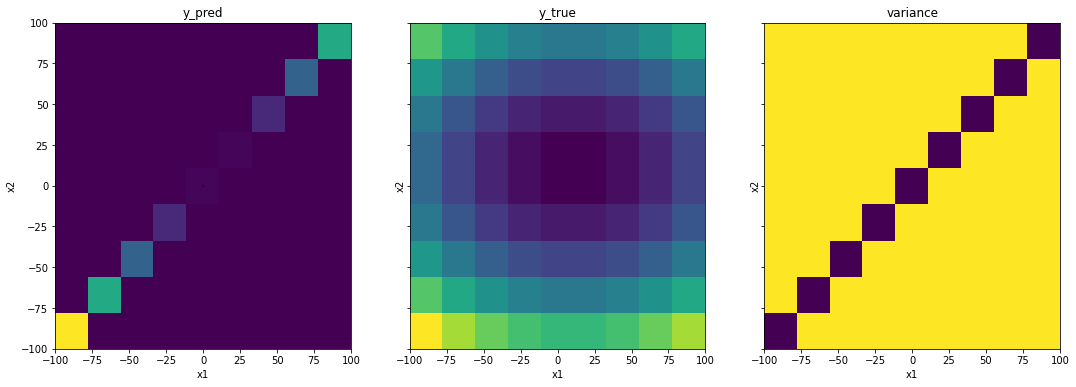

In [ ]:
#BOHACHEVSKY FUNCTIONS using tinygp (Matern series)

#BOHACHEVSKY FUNCTIONS description
X = np.linspace((-100,-100),(100,100),10)
yerr = 0.01
y = X[:,0]**2 + 2*X[:,1]**2 - 0.3*np.cos(3*np.pi*X[:,0]) - 0.4*np.cos(4*np.pi*X[:,1]) + 0.7 + yerr * np.random.normal(
    size=len(X))

X1,X2 = np.meshgrid(X[:,0], X[:,1])
y_true = X1**2 + 2*X2**2 - 0.3*np.cos(3*np.pi*X1) - 0.4*np.cos(4*np.pi*X2) +0.7
X_pred = np.vstack((X1.flatten(), X2.flatten())).T

#hyperparameters
params = {
        "log_amp": np.float64(0.3),
        "log_scale": np.zeros(2),
    }

#Kernel = Matern52
kernel = jnp.exp(params["log_amp"]) * tinygp.transforms.Linear(
        jnp.exp(-params["log_scale"]), tinygp.kernels.Matern52()
    )
gp = tinygp.GaussianProcess(kernel, X, diag=yerr**2)

#loss function
@jax.jit
def loss(params):
    return gp.log_probability(y)

#minimizing loss function
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(params)
print("Maximum likelihood parameters:")
print(soln.params)

y_pred = gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)

#finding mean and variance
gp_cond = gp.condition(y, X_pred).gp
mu, var = gp_cond.loc, gp_cond.variance
var = var.reshape(y_true.shape)

#Producing covariance elcipse
theta = np.linspace(0, 2 * np.pi, 500)[None, :]
ellipse = 0.5 * np.concatenate((np.cos(theta), np.sin(theta)), axis=0)
xy = ellipse / gp.kernel.kernel2.scale[:, None]

#Plotting results in heatmap
plotheatmap(X, y_pred, y_true, var)

#printing results, comparing trained(predicted) data vs. true value
print(f"Predicted minimum y value using GP: {y_pred.min()}")